# Demo No. 11 - Radial velocities fitting.

Following 2 demos will illustrate, how to proceed in case of the binary system with available radial velocities and photometric data. In this demo, we will focus on radial velocity data fitting using couple of methods.


In [1]:
import numpy as np
import astropy.units as u

from elisa.conf import config
from elisa.analytics import RVData
from elisa.analytics import BinarySystemAnalyticsTask


# setting up a custom logging config to prevent unreasonably long log messages during fit
config.LOG_CONFIG ='jupyter_fit_logging.json'
config.set_up_logging()  

As a start, we will create datasets containing observations of KIC 4851217 (Matson et al., 2017):

In [2]:
rv_primary = RVData.load_from_file(filename='demo_data/rv_data/rv1.dat', 
                                   x_unit=u.d, y_unit=u.km/u.s)

rv_secondary = RVData.load_from_file(filename='demo_data/rv_data/rv2.dat', 
                                     x_unit=u.d, y_unit=u.km/u.s)

As a next step, we will create an `BinarySystemAnalyticsTask`:

In [3]:
task = BinarySystemAnalyticsTask(radial_velocities={'primary': rv_primary, 'secondary': rv_secondary})

This `task` instance now contains `rv_fit` attribute in which our radial velocity fitting methods can be accessed. 

Now we have to define a dictionary containing starting values of a fit. The list of necessary fit parameters depends on which fit approach is used. In `standard` approach, component masses are fitted. On the other side, `community` approach enables to fit the model using mass ratio and parameter a sin(i) which is much more suitable for radial velocity curve fit. List of available fit parameters for each approach can be accessed here:

In [4]:
task.rv_fit.FIT_PARAMS_COMBINATIONS

{'standard': ['p__mass',
  's__mass',
  'inclination',
  'eccentricity',
  'argument_of_periastron',
  'gamma',
  'period',
  'primary_minimum_time'],
 'community': ['mass_ratio',
  'asini',
  'eccentricity',
  'argument_of_periastron',
  'gamma',
  'period',
  'primary_minimum_time']}

In case of radial velocities fitting, it is much more suitable to use `community` approach which will in general remove degeneracies in a fittimg model. 

Lets finally define our starting parameters. Starting parameters are listed in form of dictionary that contain name of the variable as a key and values contains dictionary characterizing starting value of the parameter, status of the parameter (`fixed`: True/False), the boundaries of the fitted parameter defined by `min`, `max` values and the unit in astropy format.

In [5]:
rv_initial = {
    'eccentricity': {
        'value': 0.03,
        'fixed': False,
        'min': 0.00,
        'max': 0.04
    },
    'asini': {
        'value': 12,
        'fixed': False,
        'min': 8.0,
        'max': 15,
        'unit': u.solRad
    },
    'mass_ratio': {
        'value': 1.0,
        'fixed': False,
        'min': 0.9,
        'max': 1.2
    },
    'argument_of_periastron': {
        'value': 170,
        'fixed': False,
        'min': 0,
        'max': 360,
        'unit': u.deg
    },
    'gamma': {
        'value': -25.0,
        'fixed': False,
        'min': -10.0,
        'max': -30.0,
        'unit': u.km/u.s
    },
    'period': {
        'value': 2.47028376,
        'fixed': True,
    },
    'primary_minimum_time': {
        'value': 54953.8691,
        'fixed': False,
        'min': 54953.800,
        'max': 54954.000,
        'unit': u.d
    }
}

## Least squares method 

At this point, we can perform actual fit. In current version of Elisa, two fitting methods are available, least-squares and Markov chain Monte Carlo. Lets start with the first one (this may take a few seconds):

In [6]:
fit_params = task.rv_fit.fit(x0=rv_initial, method='least_squares')

2020-03-06 10:12:02,502 - 26852 - analytics.binary.least_squares - INFO: fitting radial velocity light curve...
2020-03-06 10:12:35,961 - 26852 - analytics.binary.least_squares - INFO: fitting finished...
2020-03-06 10:12:35,973 - 26852 - analytics.binary_fit.rv_fit - INFO: Fitting and processing of results finished successfully.


The resluts of the fitting procedure are stored in `fit_params`:

In [7]:
fit_params

{'eccentricity': {'value': 0.012852504860218342, 'unit': ''},
 'asini': {'value': 11.858322580396763, 'unit': 'solRad'},
 'mass_ratio': {'value': 1.0772917624770264, 'unit': ''},
 'argument_of_periastron': {'value': 260.83381685203193, 'unit': 'degree'},
 'gamma': {'value': -24507.543773805202, 'unit': 'm/s'},
 'primary_minimum_time': {'value': 54953.872645085175, 'unit': 'd'},
 'period': {'value': 2.47028376, 'unit': 'd'},
 'r_squared': {'value': 0.993533669150582}}

These results can be stored and reloaded in json format using commands `task.rv_fit.store_parameters(filename=)` and `task.rv_fit.load_parameters(filename=)`.

Finally, we can visualize the resulting fit:

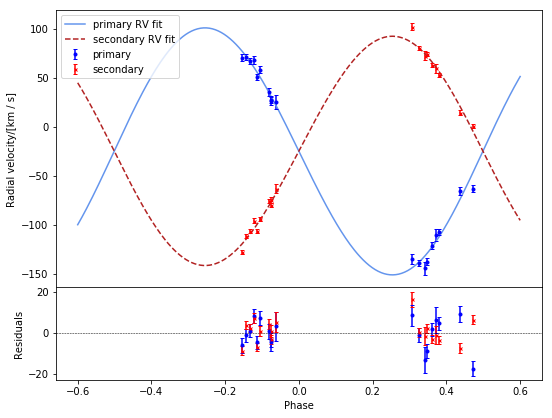

In [8]:
task.rv_fit.plot.model()

## Markov chain Monte Carlo (MCMC)

Using the MCMC we can estimate confidence intervals of the fitted parameters which was not possible in least squares method. Unfortunatelly, this capability is at the expense of speed and therefore this method is meant to be used as a follow-up to the least squares method. To speed-up the initiall burn-in phase, we will update the current initial values to the results obtained in least squares method:

In [9]:
for param in rv_initial.keys():
    rv_initial[param]['value'] = fit_params[param]['value'] 

Updated starting parameters can be now used in a very similar fashion to perform MCMC sampling

In [10]:
fit_params_mcmc = task.rv_fit.fit(x0=rv_initial, method='mcmc', nsteps=1000, progress=True)

2020-03-06 10:12:36,596 - 26852 - analytics.binary.mcmc - INFO: starting mcmc
2020-03-06 10:12:36,597 - 26852 - analytics.binary.mcmc - INFO: starting singlecore mcmc
2020-03-06 10:12:36,598 - 26852 - analytics.binary.mcmc - INFO: running burn-in...


100%|██████████| 100/100 [00:08<00:00, 12.09it/s]

2020-03-06 10:12:44,988 - 26852 - analytics.binary.mcmc - INFO: running production...



100%|██████████| 1000/1000 [01:16<00:00, 13.12it/s]


2020-03-06 10:14:01,439 - 26852 - analytics.binary.mcmc - INFO: MCMC chain, variable`s labels and normalization constants were stored in: /home/cepheus/.elisa/2020-03-06/2020-03-06T10.14.01.json
2020-03-06 10:14:01,467 - 26852 - analytics.binary_fit.rv_fit - INFO: Fitting and processing of results finished successfully.


We will now store the resulting parameters into file that we will use later:

In [11]:
param_file = 'demo_data/aux/rv_mcmc_params.json'
task.rv_fit.store_parameters(filename=param_file)

We can inspect the results by examining a correlation diagrams in the corner plot:

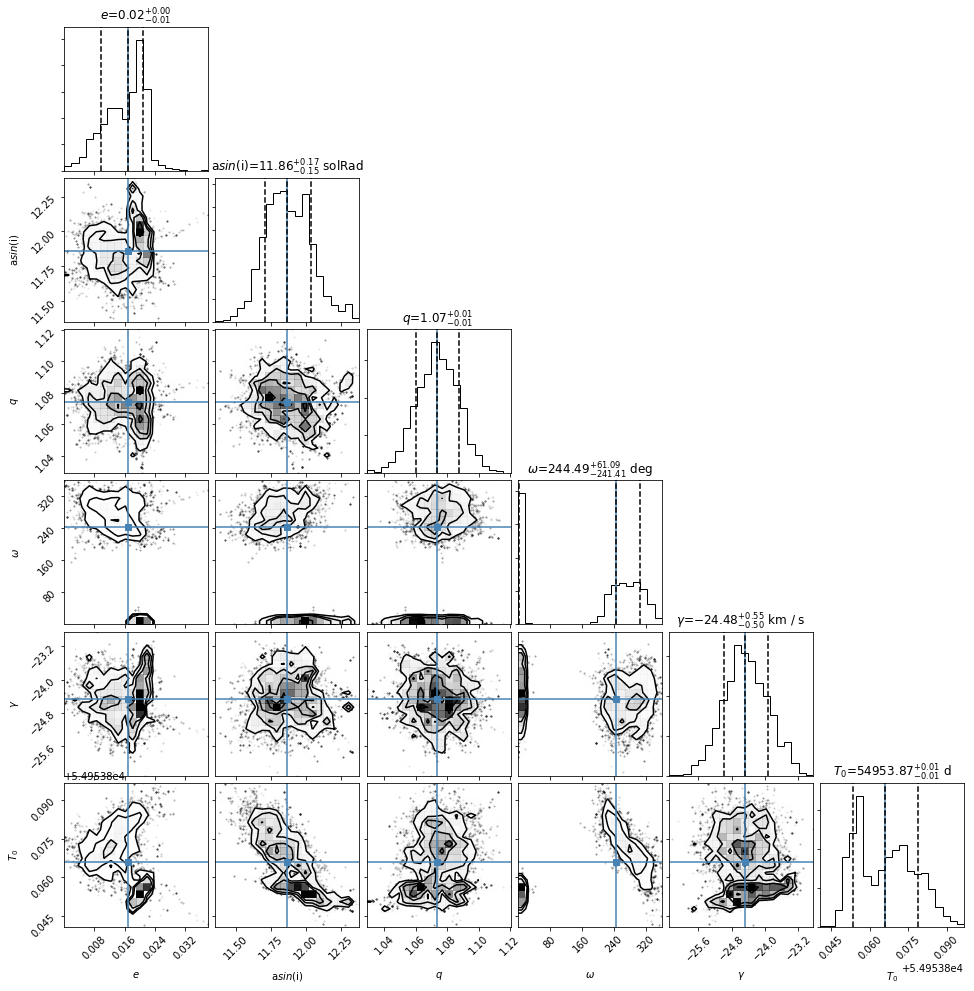

In [12]:
task.rv_fit.plot.corner(truths=True)

Traces can be also investgated:

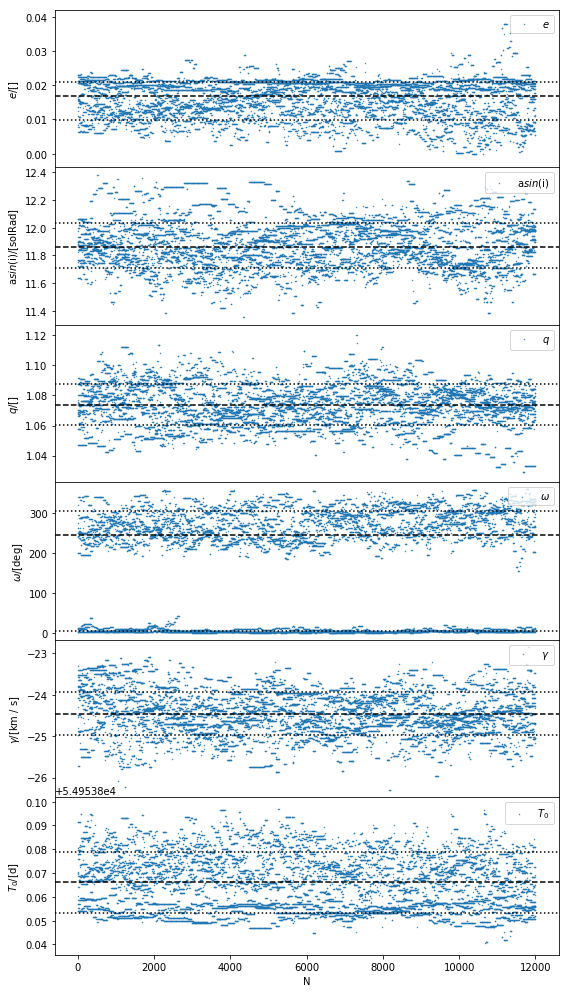

In [13]:
task.rv_fit.plot.traces(truths=True)

Along with autocorrelation function and autocorrelation times:

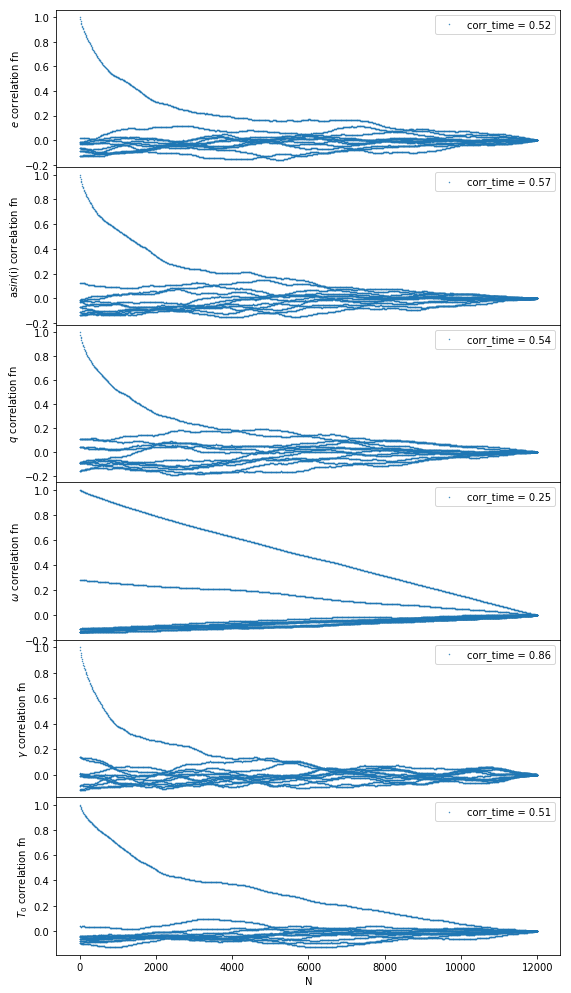

In [14]:
task.rv_fit.plot.autocorrelation()

As you can (probably) see in this example, default `n_steps/10` `burn_in` phase was not sufficient to de-correlate all of the chains. This can be remedied easily by incrasing the the number of iterations or by specifying longer `burn_in` argument in `fit` function.

Due to the fact, that the MCMC method is very time demanding method, the resulting chain is stored automatically in your `~/.elisa/yy-mm-dd` directory. The location of the chain from the last run is stored in this `rv_fit` attribute:

In [15]:
chain_path = task.rv_fit.flat_chain_path
task.rv_fit.flat_chain_path

'/home/cepheus/.elisa/2020-03-06/2020-03-06T10.14.01'

Therefore, the previous run can can be revisited and reanalysed, provided that you also stored your fit parameters, that contains all your fixed and constrained parameters as well. 

Reloading previuous fit should look like this (after defining `Dataset` and `BinarySystemAnalyticsTask` instances):

In [16]:
task.rv_fit.load_parameters(filename=param_file)
task.rv_fit.load_chain(filename=chain_path)   # this line is not necessary in case of the least squares method

(array([[0.27146495, 0.54591875, 0.59086587, 0.7672469 , 0.69030703,
         0.34769328],
        [0.34376891, 0.53203342, 0.52575286, 0.72984041, 0.7482614 ,
         0.39022192],
        [0.53084371, 0.55619945, 0.56808067, 0.03140288, 0.68962796,
         0.28488512],
        ...,
        [0.53035962, 0.54587378, 0.54501048, 0.02307068, 0.70397494,
         0.28064651],
        [0.39664368, 0.55861075, 0.61414842, 0.93555422, 0.73473496,
         0.29014173],
        [0.13644497, 0.56890811, 0.60605414, 0.88829063, 0.7527972 ,
         0.32504272]]),
 ['eccentricity',
  'asini',
  'mass_ratio',
  'argument_of_periastron',
  'gamma',
  'primary_minimum_time'],
 {'inclination': [0, 180],
  'eccentricity': [0.0, 0.04],
  'argument_of_periastron': [0.0, 360.0],
  'gamma': [-10000.0, -30000.0],
  'p__mass': [0.1, 50],
  's__mass': [0.1, 50],
  'p__t_eff': [3500.0, 50000.0],
  's__t_eff': [3500.0, 50000.0],
  'p__metallicity': [-2.5, 0.5],
  's__metallicity': [-2.5, 0.5],
  'p__surface_p

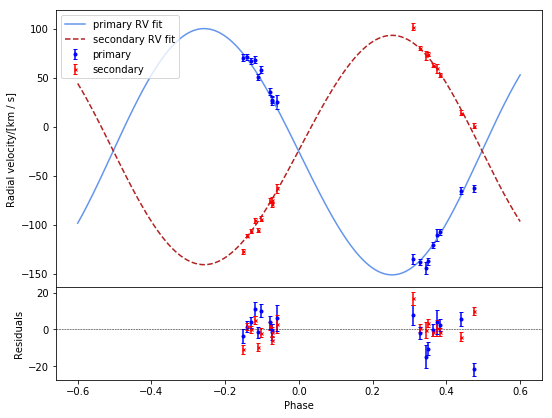

In [17]:
task.rv_fit.plot.model()

## References:

Matson, R. A.; Gies, D. R.; Guo, Z.; Williams, S. J. 2017, AJ, 154, 6, 216